# HR Analytics: Job Change of Data Scientists

This dataset represents a use case in which a company wants to hire data scientists among participants of the courses conducted by the company itself. The company wants to identify which of the participants are really eager to change jobs, so it can focus its efforts on this set of participants and save money and work.

The dataset thus represents a conjunction of demographic, social and labour factors that push a worker to change jobs and drives attrition. By examining the data presented, and modelling a solution for the company at hand, we may be able to understand better these factors.

In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Recall, FalsePositives, FalseNegatives

## Data Loading

In [2]:
train = pd.read_csv('../data/aug_train.csv')

In [3]:
train.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [4]:
train.describe()

,enrollee_id,city_development_index,training_hours,target
count,19158.000000,19158.000000,19158.000000,19158.000000
mean,16875.358179,0.828848,65.366896,0.249348
std,9616.292592,0.123362,60.058462,0.432647
min,1.000000,0.448000,1.000000,0.000000
25%,8554.250000,0.740000,23.000000,0.000000
50%,16982.500000,0.903000,47.000000,0.000000
75%,25169.750000,0.920000,88.000000,0.000000
max,33380.000000,0.949000,336.000000,1.000000


As we can see, only 2 variables (apart from the id and the target variable) are numeric, which means that some techniques to deal with categorical variables are going to be considered. Furthermore, looking at the target variable distribution, we perceive that the data is not balanced, as the mean is far from 0.5 which would mean that both groups are equally represented.

## Exploratory Data Analysis

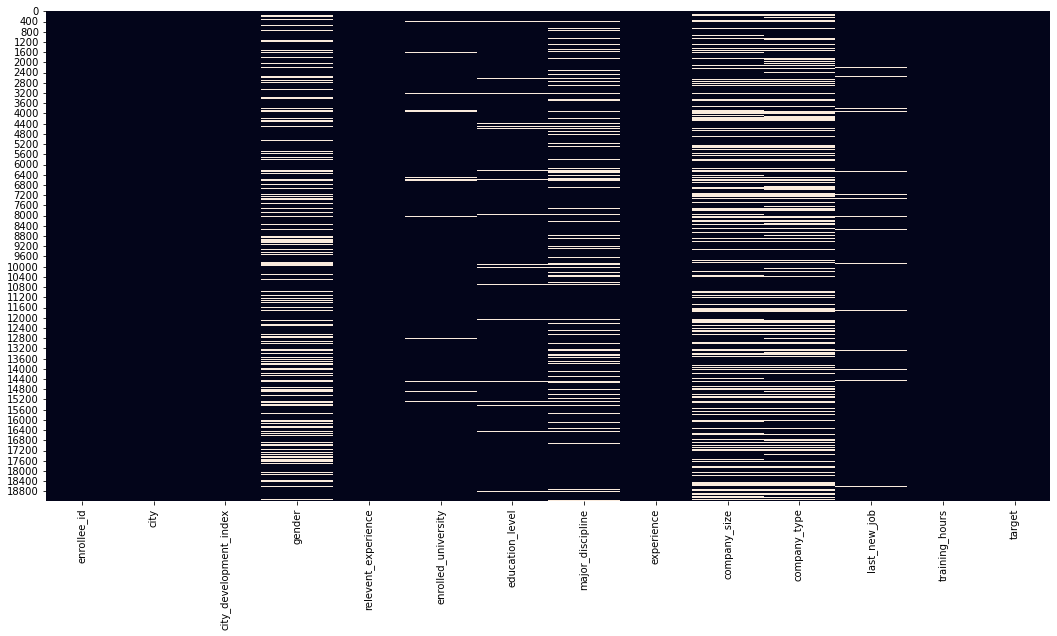

In [5]:
plt.subplots(figsize=(18, 9))
sns.heatmap(train.isna(), cbar=False)
plt.show()

In [6]:
train.isna().sum() / train.shape[0]

enrollee_id               0.000000
city                      0.000000
city_development_index    0.000000
gender                    0.235306
relevent_experience       0.000000
enrolled_university       0.020148
education_level           0.024011
major_discipline          0.146832
experience                0.003393
company_size              0.309949
company_type              0.320493
last_new_job              0.022080
training_hours            0.000000
target                    0.000000
dtype: float64

Some variables as the gender or the company type and size represent a big enough number of missing values, reaching more than 20 and 30% respectively. Looking at our heatmap, we see that those missing values are distributed accross all the dataset, so no particular segment is affected more than the others.

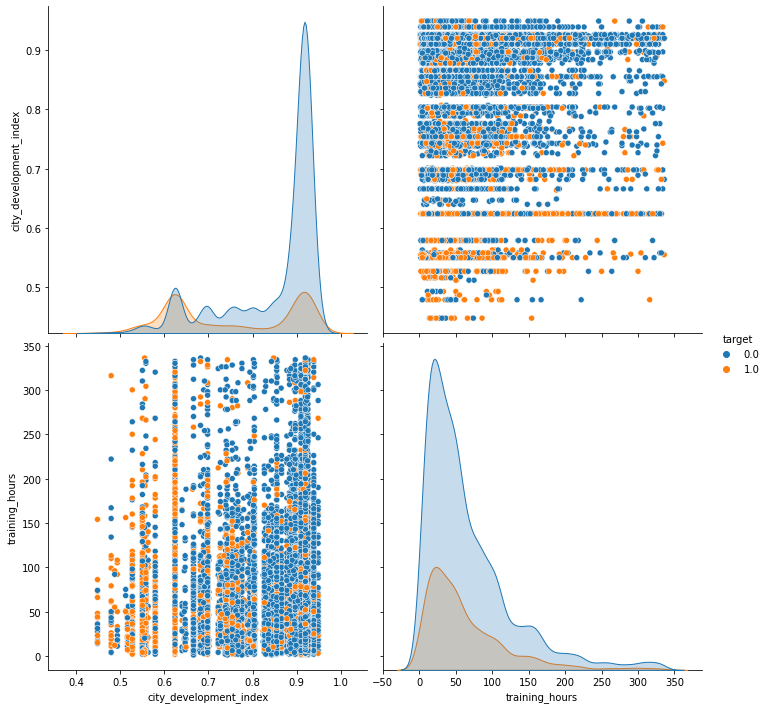

In [7]:
sns.pairplot(train.drop('enrollee_id', axis=1), hue='target', height=5)
plt.show()

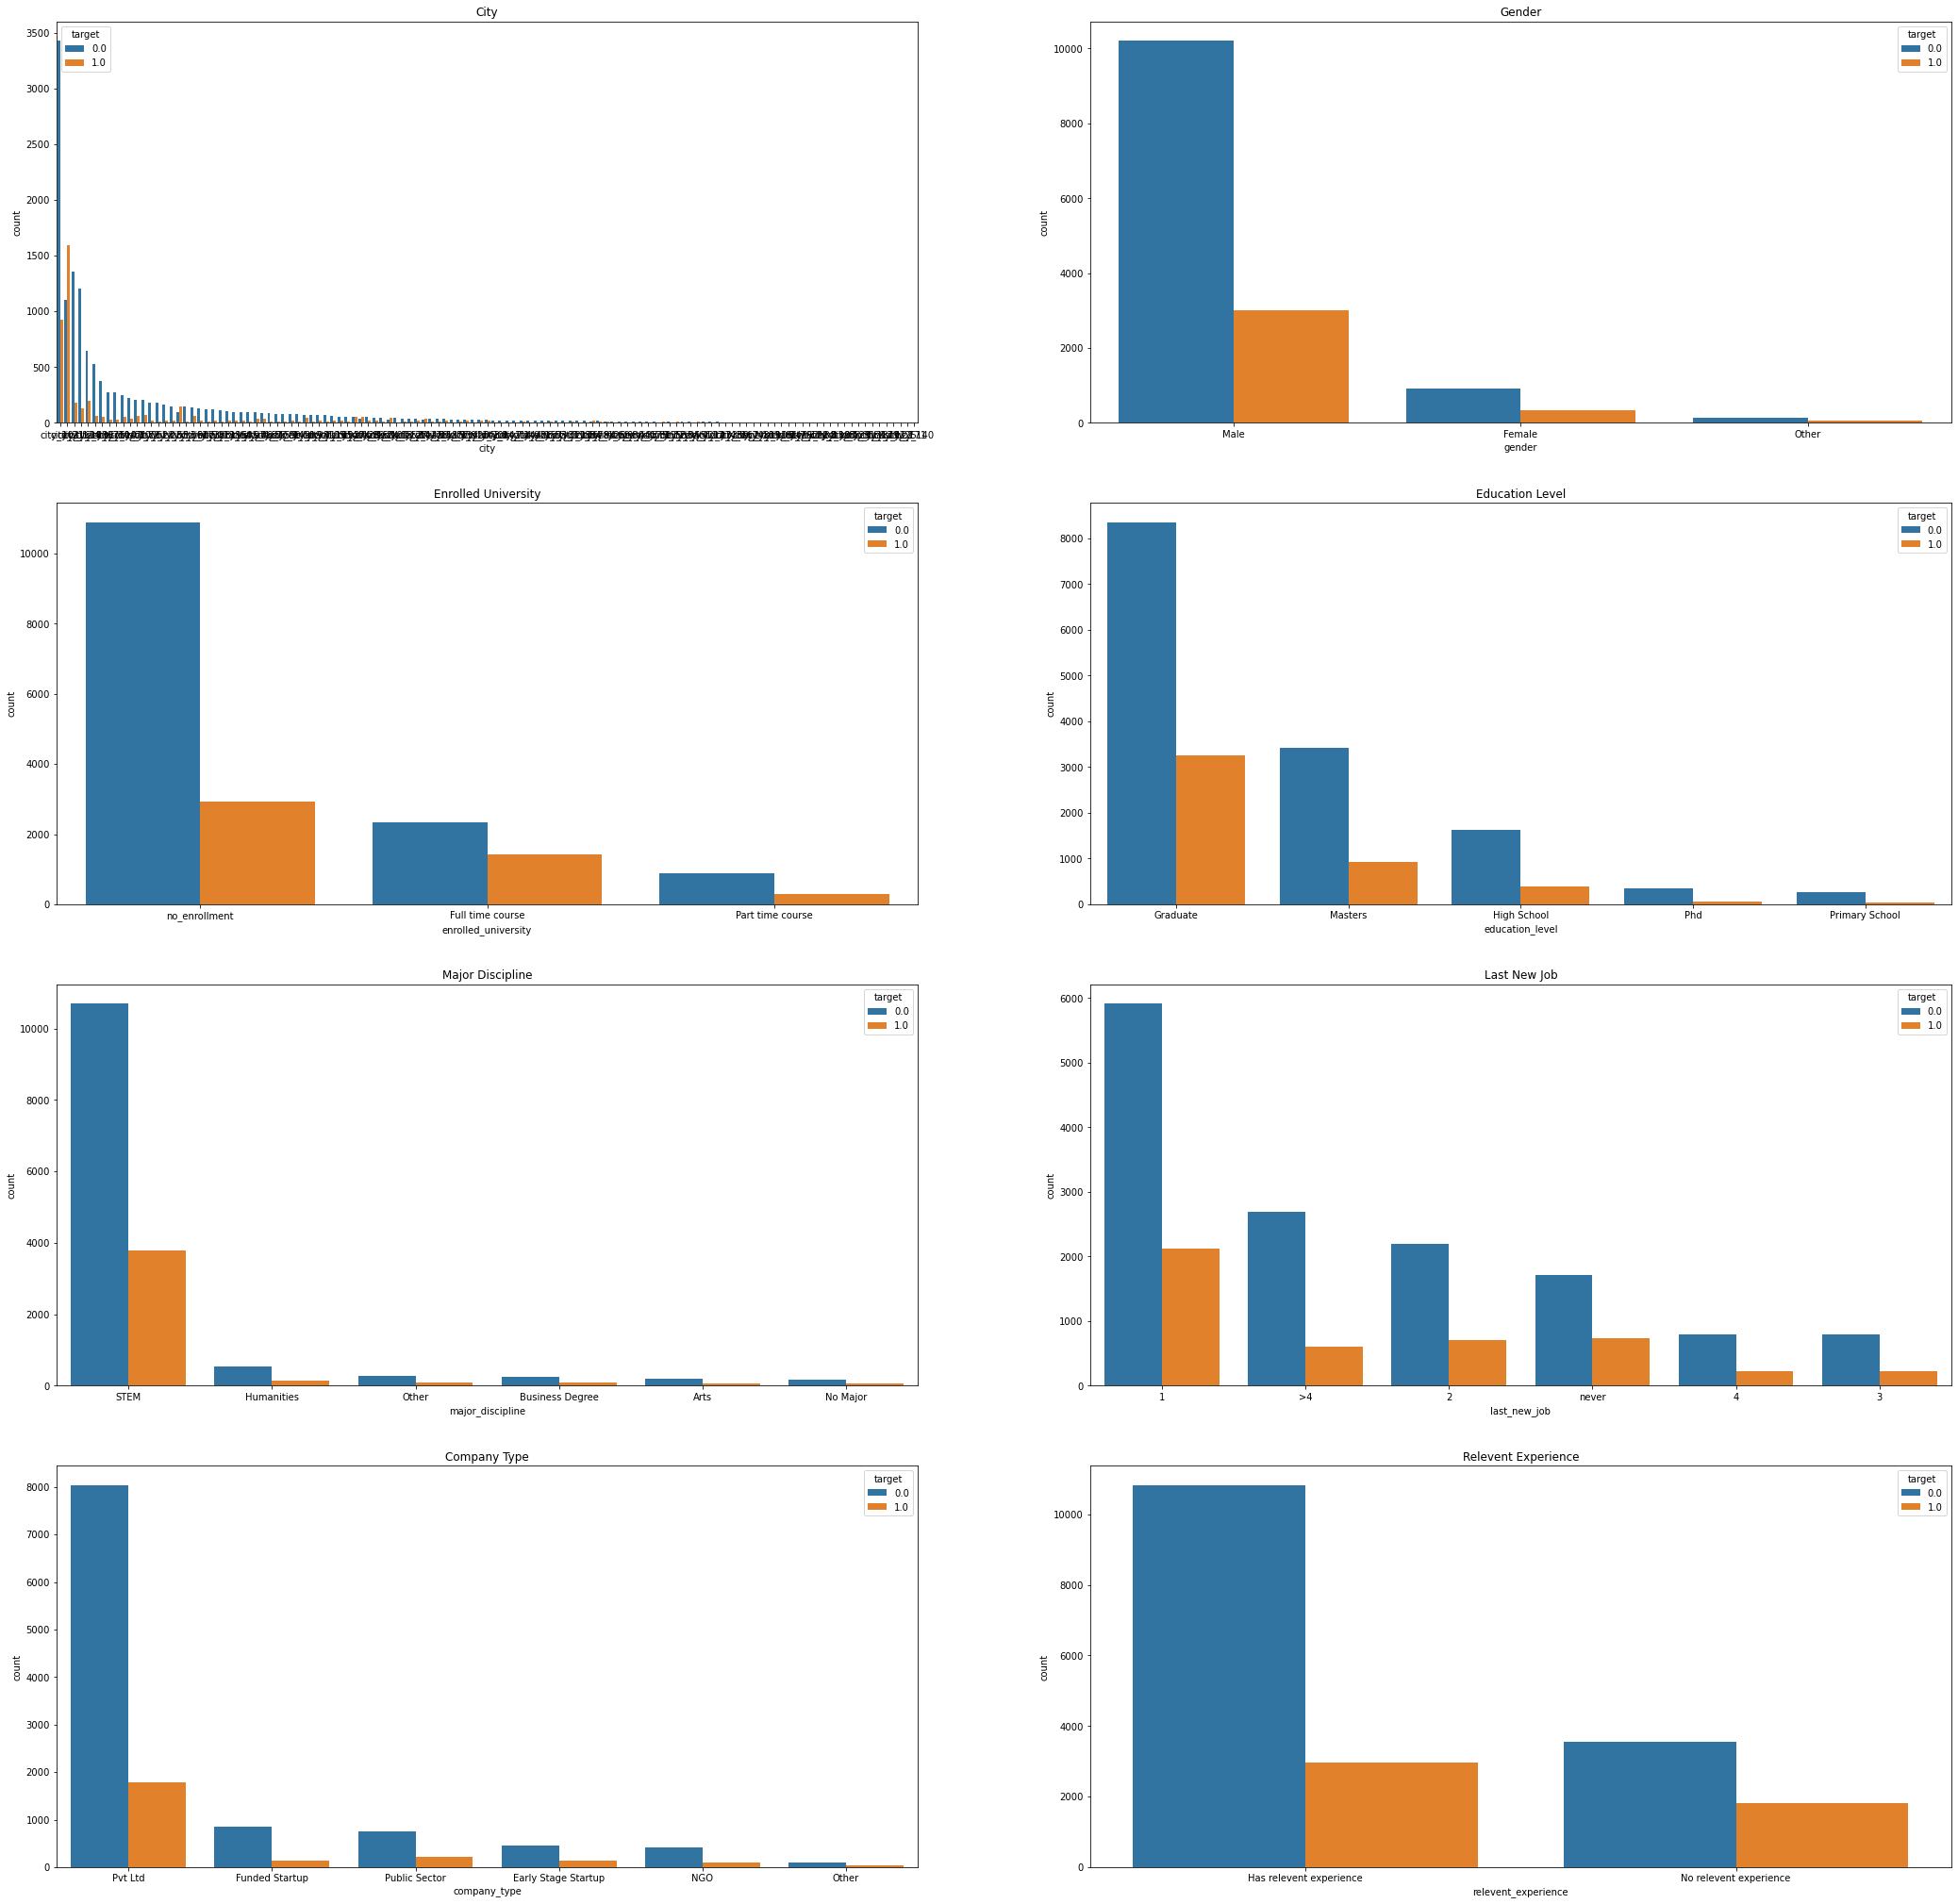

In [8]:
fig, ax = plt.subplots(figsize=(36, 36), nrows=4, ncols=2)

sns.barplot(
    data=train.groupby(['target', 'city']).agg(count=('enrollee_id', pd.Series.count)).reset_index().sort_values(by='count', ascending=False),
    x='city', y='count', hue='target',  ax=ax[0,0]
)
ax[0, 0].set_title('City')
sns.barplot(
    data=train.groupby(['target', 'gender']).agg(count=('enrollee_id', pd.Series.count)).reset_index().sort_values(by='count', ascending=False),
    x='gender', y='count', hue='target',  ax=ax[0,1]
)
ax[0, 1].set_title('Gender')

sns.barplot(
    data=train.groupby(['target', 'enrolled_university']).agg(count=('enrollee_id', pd.Series.count)).reset_index().sort_values(by='count', ascending=False),
    x='enrolled_university', y='count', hue='target',  ax=ax[1,0]
)
ax[1, 0].set_title('Enrolled University')
sns.barplot(
    data=train.groupby(['target', 'education_level']).agg(count=('enrollee_id', pd.Series.count)).reset_index().sort_values(by='count', ascending=False),
    x='education_level', y='count', hue='target',  ax=ax[1,1]
)
ax[1, 1].set_title('Education Level')

sns.barplot(
    data=train.groupby(['target', 'major_discipline']).agg(count=('enrollee_id', pd.Series.count)).reset_index().sort_values(by='count', ascending=False),
    x='major_discipline', y='count', hue='target',  ax=ax[2,0]
)
ax[2, 0].set_title('Major Discipline')
sns.barplot(
    data=train.groupby(['target', 'last_new_job']).agg(count=('enrollee_id', pd.Series.count)).reset_index().sort_values(by='count', ascending=False),
    x='last_new_job', y='count', hue='target',  ax=ax[2,1]
)
ax[2, 1].set_title('Last New Job')

sns.barplot(
    data=train.groupby(['target', 'company_type']).agg(count=('enrollee_id', pd.Series.count)).reset_index().sort_values(by='count', ascending=False),
    x='company_type', y='count', hue='target',  ax=ax[3,0]
)
ax[3, 0].set_title('Company Type')
sns.barplot(
    data=train.groupby(['target', 'relevent_experience']).agg(count=('enrollee_id', pd.Series.count)).reset_index().sort_values(by='count', ascending=False),
    x='relevent_experience', y='count', hue='target',  ax=ax[3,1]
)
ax[3, 1].set_title('Relevent Experience')

plt.show()

Looking at the numerical variables, we see that those the distribution of workers willing to leave their job and those who don't are balanced in the cities whose development index is lower, while on the cities with bigger indexes the distribution is unbalanced and there are more workers unwilling to move between jobs. On the other hand, training hours' distribution is similar for both groups.

Looking at the categorical variables, the main insights here are that the workers with no relevent experience are statistically more willing to change jobs than the ones with experience, as so do the workers which are full-time enrolled in the university. Regarding the other variables, we do see small changes in the distribution between groups in some of them, but perhaps the other helpful distribution here would be the one from the cities, as there are some cities that present an interesting number of people willing to change jobs, so maybe HR should target those employees too. 

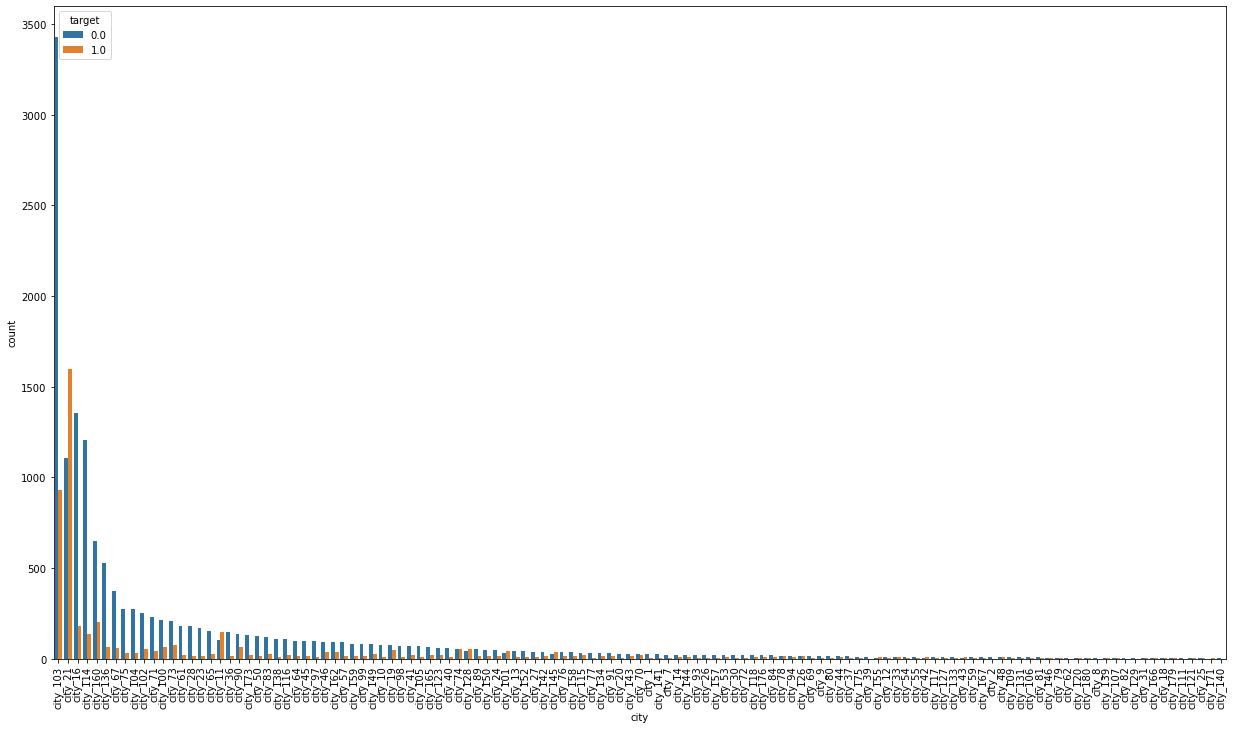

In [9]:
fig, ax = plt.subplots(figsize=(21, 12))

sns.barplot(
    data=train.groupby(['target', 'city']).agg(count=('enrollee_id', pd.Series.count)).reset_index().sort_values(by='count', ascending=False),
    x='city', y='count', hue='target',  ax=ax
)
plt.xticks(rotation=90)
plt.show()

Looking closely, the cities mentioned before are the `city_21` and `city_11` sorted by the number of participants. There are also some other cities where the opposite is seen, and in some cities like `city_28` its workers seem unwilling to move away because of work changes.

## Column Dropping 

The column referring to the ID of the enrollee is not needed, so we may drop it. Also, it is a good moment to divide our dataset into a matrix of data to train our model with and a target vector y.

In [10]:
X = train.drop('target', axis=1)
y = train.target

X_dropped = train.drop(['enrollee_id', 'target'], axis=1)

## NA Imputation

Now that we took a look at our data, we have a deeper understanding of it and may choose an imputation strategy for each of the columns of our dataset. Let's remember which are the main strategies in these cases:

- **NA Filling:** Filling the null values with a value inferred from the rest of the values of that column.
- **NA Dropping:** Dropping the rows which contain null values in a certain column.
- **Column Dropping:** Dropping the column as a whole, that may be useful when the proportion of null values is so big that no insight might be inferred

In this particular case, null values might be due to the lack of response from the participants. Nevertheless, there are some predominances in the data that might be used to fill the missing values, as we see that in some cases like in the major discipline most of the participants came from STEM, and furthermore we do not appreciate differences in the target distribution accross the different values of that column.

For those columns we are going to fill the missing values with the most frequent value:

In [11]:
X_dropped.gender.fillna('Other', inplace=True) # unknown placeholder
X_dropped.enrolled_university.fillna('no_enrollment', inplace=True) # unknown placeholder
X_dropped.education_level.fillna('Graduate', inplace=True) # most common
X_dropped.last_new_job.fillna('never', inplace=True) # unknown placeholder
X_dropped.major_discipline.fillna('STEM', inplace=True) # most common
X_dropped.experience.fillna('>20', inplace=True) # most common
X_dropped.company_type.fillna('Pvt Ltd', inplace=True) # most common
X_dropped.company_size.fillna('50-99', inplace=True) # most common

On the other hand, there are some variables that present too many null values, like `gender`, `company_size` and `company_type`. On those columns we are going to fit a KNN Classifier that will give us some insights about which values are more probable to be missing on each row:

## Data Scaling

In order to make our algorithms perform faster and converge easier, we need to put our numeric values in a similar scale. For that purpose we are going to use the `StandardScaler` class of sklearn:

In [108]:
scal = StandardScaler()
X_dropped[
    ['city_development_index', 'training_hours']
] = scal.fit_transform(X_dropped[['city_development_index','training_hours']])

## One Hot Encoding

Our models understand numbers, as they are based on calculus and linear algebra they need our variables to be on a numeric scale. As we saw while analyzing our data, most of our variables are in fact categories, so we are going to use the class `OneHotEncoder` of scikit-learn to convert them to a numeric matrix:

In [109]:
# Selecting the columns to transform
ohenc_columns = X_dropped.drop([
    'city_development_index', 'training_hours',
], axis=1).columns

# Creating and fitting our encoder
ohenc = OneHotEncoder(sparse=False, drop='first')
ohenc_matrix = ohenc.fit_transform(X_dropped[ohenc_columns])

# Adding the new columns to our data
X_encoded = np.concatenate([
    X_dropped.drop(ohenc_columns, axis=1).values, ohenc_matrix
], axis=1)

## Train-Test Split

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, train_size=0.8,)

## Data Oversampling 

As we previously saw, our classes 0 and 1 have not an equal proportion of examples in our dataset. This may make our dataset hard to train as the model would tend to output the class with the majority of the examples as its cost function would take lesser values while outputing that class.

For this reason, we may use the SMOTE algorithm to oversample our data and create a more equally distributed dataset:

In [62]:
oversampler = SMOTE()
X_oversampled, y_oversampled = oversampler.fit_resample(X_train, y_train)

## Modelling 

### Logistic Regression

In [63]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
}
log_grid = GridSearchCV(
    LogisticRegression(max_iter=10000),
    param_grid=param_grid,
    n_jobs=-1,
    cv=5
)
log_grid.fit(X_oversampled, y_oversampled)
log_model = log_grid.best_estimator_
y_pred_log = log_model.predict(X_test)

In [97]:
print(accuracy_score(y_pred_log, y_test))

0.7492171189979123


In [98]:
print(recall_score(y_pred_log, y_test))

0.49447310243183495


In [65]:
print(confusion_matrix(y_pred_log, y_test))

[[2200  275]
 [ 686  671]]


In [66]:
print(classification_report(y_pred_log, y_test))

              precision    recall  f1-score   support

         0.0       0.76      0.89      0.82      2475
         1.0       0.71      0.49      0.58      1357

    accuracy                           0.75      3832
   macro avg       0.74      0.69      0.70      3832
weighted avg       0.74      0.75      0.74      3832



### Naive Bayes

In [83]:
nb_model = GaussianNB()
nb_model.fit(X_oversampled, y_oversampled)
y_pred_nb = nb_model.predict(X_test)

In [84]:
print(accuracy_score(y_pred_nb, y_test))

0.38308977035490605


In [99]:
print(recall_score(y_pred_nb, y_test))

0.27246469833119386


In [85]:
print(confusion_matrix(y_pred_nb, y_test))

[[ 619   97]
 [2267  849]]


In [86]:
print(classification_report(y_pred_nb, y_test))

              precision    recall  f1-score   support

         0.0       0.21      0.86      0.34       716
         1.0       0.90      0.27      0.42      3116

    accuracy                           0.38      3832
   macro avg       0.56      0.57      0.38      3832
weighted avg       0.77      0.38      0.40      3832



In [71]:
param_grid = {
    'n_neighbors': range(1, 20, 2),
}
knn_grid = GridSearchCV(
    KNeighborsClassifier(n_jobs=-1),
    param_grid=param_grid,
    cv=5
)
knn_grid.fit(X_train, y_train)
knn_model = knn_grid.best_estimator_
y_pred_knn = knn_model.predict(X_test)

NameError: name 'KNeighborsClassifier' is not defined

In [72]:
print(accuracy_score(y_pred_knn, y_test))

NameError: name 'y_pred_knn' is not defined

In [73]:
print(confusion_matrix(y_pred_knn, y_test))

NameError: name 'y_pred_knn' is not defined

In [74]:
print(classification_report(y_pred_knn, y_test))

NameError: name 'y_pred_knn' is not defined

### Random Forest

In [87]:
param_grid = {
    'n_estimators': [5, 20, 50, 100, 200],
    'min_samples_split': [2, 5, 10]
}
rfor_grid = GridSearchCV(
    RandomForestClassifier(n_jobs=-1),
    param_grid=param_grid,
    n_jobs=-1,
    cv=5
)
rfor_grid.fit(X_oversampled, y_oversampled)
rfor_model = rfor_grid.best_estimator_
y_pred_rfor = rfor_model.predict(X_test)

In [88]:
print(accuracy_score(y_pred_rfor, y_test))

0.7612212943632568


In [100]:
print(recall_score(y_pred_rfor, y_test))

0.519496855345912


In [89]:
print(confusion_matrix(y_pred_rfor, y_test))

[[2504  533]
 [ 382  413]]


In [90]:
print(classification_report(y_pred_rfor, y_test))

              precision    recall  f1-score   support

         0.0       0.87      0.82      0.85      3037
         1.0       0.44      0.52      0.47       795

    accuracy                           0.76      3832
   macro avg       0.65      0.67      0.66      3832
weighted avg       0.78      0.76      0.77      3832



### Keras with regularization

In [104]:
nn_model = Sequential()

nn_model.add(Dense(500, activation='relu', input_shape=(X_train.shape[1], ), kernel_regularizer=l2(0.01)))
nn_model.add(BatchNormalization())
nn_model.add(Dropout(0.1))

nn_model.add(Dense(250, activation='relu', kernel_regularizer=l2(0.01)))
nn_model.add(BatchNormalization())
nn_model.add(Dropout(0.1))

nn_model.add(Dense(150, activation='relu', kernel_regularizer=l2(0.01)))
nn_model.add(Dropout(0.1))

nn_model.add(Dense(275, activation='relu', kernel_regularizer=l2(0.01)))
nn_model.add(Dropout(0.1))

nn_model.add(Dense(1, activation='sigmoid'))
nn_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', Recall(), FalsePositives(), FalseNegatives()]
)

In [105]:
early_stopping = EarlyStopping(patience=15, min_delta=0.1, restore_best_weights=True)
history = nn_model.fit(
    X_oversampled,
    y_oversampled,
    epochs=100,
    batch_size=512,
    validation_split=0.2,
    callbacks=[early_stopping]
)

Epoch 1/100


2022-02-13 00:41:56.787205: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - ETA: 0s - loss: 7.2796 - accuracy: 0.7386 - recall_3: 0.5778 - false_positives_3: 1896.0000 - false_negatives_3: 2912.0000

2022-02-13 00:41:58.063117: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - 2s 35ms/step - loss: 7.2796 - accuracy: 0.7386 - recall_3: 0.5778 - false_positives_3: 1896.0000 - false_negatives_3: 2912.0000 - val_loss: 4.7580 - val_accuracy: 0.4535 - val_recall_3: 0.4535 - val_false_positives_3: 0.0000e+00 - val_false_negatives_3: 2513.0000
Epoch 2/100
36/36 [==============================] - 1s 25ms/step - loss: 3.0983 - accuracy: 0.7666 - recall_3: 0.6519 - false_positives_3: 1892.0000 - false_negatives_3: 2401.0000 - val_loss: 2.1332 - val_accuracy: 0.8665 - val_recall_3: 0.8665 - val_false_positives_3: 0.0000e+00 - val_false_negatives_3: 614.0000
Epoch 3/100
36/36 [==============================] - 1s 26ms/step - loss: 1.4405 - accuracy: 0.7721 - recall_3: 0.6870 - false_positives_3: 2032.0000 - false_negatives_3: 2159.0000 - val_loss: 1.2111 - val_accuracy: 0.9989 - val_recall_3: 0.9989 - val_false_positives_3: 0.0000e+00 - val_false_negatives_3: 5.0000
Epoch 4/100
36/36 [==============================] - 1s 25ms/step

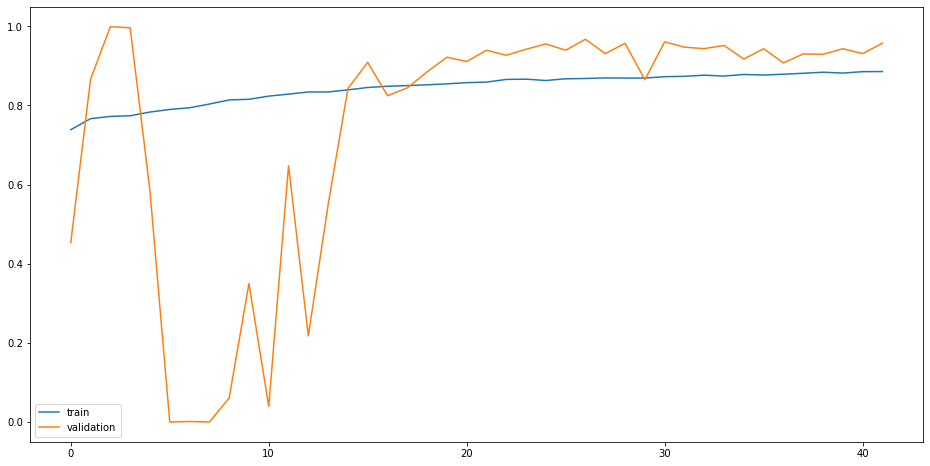

In [106]:
plt.subplots(figsize=(16, 8))
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.show()

In [107]:
print(nn_model.evaluate(X_test, y_test))

120/120 [==============================] - 1s 9ms/step - loss: 0.7892 - accuracy: 0.7038 - recall_3: 0.6258 - false_positives_3: 781.0000 - false_negatives_3: 354.0000
[0.7892184257507324, 0.7038100361824036, 0.6257928013801575, 781.0, 354.0]


## Conclusions

Finally, after modelling our data we may see that the Neural Network with regularization was the model with better results, reaching an accuracy of 70.4% and a recall of 62.6% on the test set, which is not great but still quite good results given the unbalanced nature of our data.